# The double integrator example as a hybrid system

## Definition of the optimal control problem

Here we study a double integrator system as a time optimal control problem. A specifity of our study is that we will consider it as a hybrid system, namely a dynamic system which dynamics changes depending on some conditions. In our case, the system goes through three stages:

* In the first region ($\mathbb{R}⁻\setminus[-0.65, 0]$), we lose the ability to change the control of our system: the control becomes a constant, and has to be in [-1, 1];
* In the second region ($[-0.65, 0]$), the control is set to zero and cannot be changed;
* In the third region, we can change the control at will, and has to be in [-1, 1].

The corresponding problem is defined below:

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min T, \\[0.5em]
        \dot{x}_1(t) = x_2(t) \\
        \dot{x}_2(t) =\mathbb{1}_{\mathbb{R}⁻\setminus[-0.65, 0]}(x_1(t))\lambda + (1 - \mathbb{1}_{\mathbb{R}⁻}x_1(t))  u(t),  \\[0.5em]
        \lambda,u(t) \in [-1, 1], \\[0.5em]
        x(0) = x_0,\quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$

In the following, we will consider $\lambda$ as a constant parameter of the system. In order to do that, we will take it as another state of the system, with no dynamics.

## General idea

Here we offer a method to solve this kind of problem by using first direct solving and then indirect solving, which is the standard. The main difference is that we also have to do additional analysis regarding the different phases before doing indirect solving.

[Thumbnail](control-loss.jpg)

In [1]:
# Imports for direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving

# Imports to plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirectSolution
    t; x1; x2; x3; p1; p2 ; u # x3 denotes the extended state i.e. λ
end;

In [3]:
# Parameters
t0  = 0.                  # initial time
x1f = 0.                  # Final position
x2f = 0.
M   = 1.0                 # control bound
no_control_bound = -0.65; # lower bound for no control region

In [4]:
# Heaviside regularization
function  G(x, threshold=0.)
    n =  10. # regularization stiffness
    if - 1/(2*n) < x - threshold < 1/(2*n)
        return 1. - 3*abs2(n*(x-threshold) + 0.5) + 2*abs2(n*(x-threshold) + 0.5)*(n*(x-threshold) + 0.5)
    elseif x - threshold ≤ - 1/(2*n)
        return 1.
    else x - threshold ≥ 1/(2*n)
        return 0.
    end
end;

In [5]:
function DI(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)

    # register G function with 1 argument
    register(sys, :G, 2, G; autodiff = true)
    
    N  = nsteps     # Grid size

    @variables(sys, begin
        x1[1:N+1]    # x1
        x2[1:N+1]    # x2
        x3[1:N+1]    ##### x3=λ #####
        -M ≤ u[i=1:N+1] ≤ M # Control
        0. ≤ Δt ≤ 1. # contraints may be "superflues"
    end)

    # Objective
    @objective(sys, Min, Δt)
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1] - x0[1] == 0
        con_x20, x2[1] - x0[2] == 0
        con_x30, -M ≤ x3[1] ≤ M     # parameter lambda constraint
        con_x1f, x1[N+1] - x1f == 0
        con_x2f, x2[N+1] - x2f == 0
        con_x3f, -M ≤ x3[N+1] ≤ M   # parameter lambda constraint
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1], x3[j]*G(x1[j], no_control_bound) + (1. - G(x1[j], 0.))*u[j]) # regularized dynamics
    @NLexpression(sys, dx3[j = 1:N+1], 0.) # augmented dynamics
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
        con_dx3[j=1:N], x3[j+1] == x3[j]
    end);

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    x3 = value.(x3)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)

    
    px10 = dual(con_x10)
    px20 = dual(con_x20)
    px1f = dual(con_x1f)
    px2f = dual(con_x2f)

    if(px10*dual(con_dx1[1])<0); px10 = -px10; end
    if(px20*dual(con_dx2[1])<0); px20 = -px20; end
    if(px1f*dual(con_dx1[N])<0); px1f = -px1f; end
    if(px2f*dual(con_dx2[N])<0); px2f = -px2f; end

   # H = px1 * x2 + px2 * u > 0, according to Pontryagin Maximum Principle convention
    if (px10 * x2[1] + px20 * u[1] < 0) 
        sign = -1.0 # switch sign of dual variables
    else
        sign =  1.0
    end

     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2; px1f]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2; px2f]; # We add the multiplier from the limit conditions

     p1 = sign * [px10; px1[1:N-1]; px1f]; # We add the multiplier from the limit conditions
     p2 = sign * [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

     return DirectSolution(t, x1, x2, x3, p1, p2, u)

end;

In [6]:
# Solving
x0_ref    = [-1.; 0.; ]
direct_sol= DI(x0_ref);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3204
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      805
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      604
Total number of in

In [7]:
# Value of the λ parameter, namely the constant control applied in the negative region
direct_sol.x3[1]

# Retrieving the corresponding switching time for plotting
N = length(direct_sol.t)
switch_index = findall(direct_sol.x1[2:N] .> no_control_bound)[1]; # switch from u = λ to u = 0

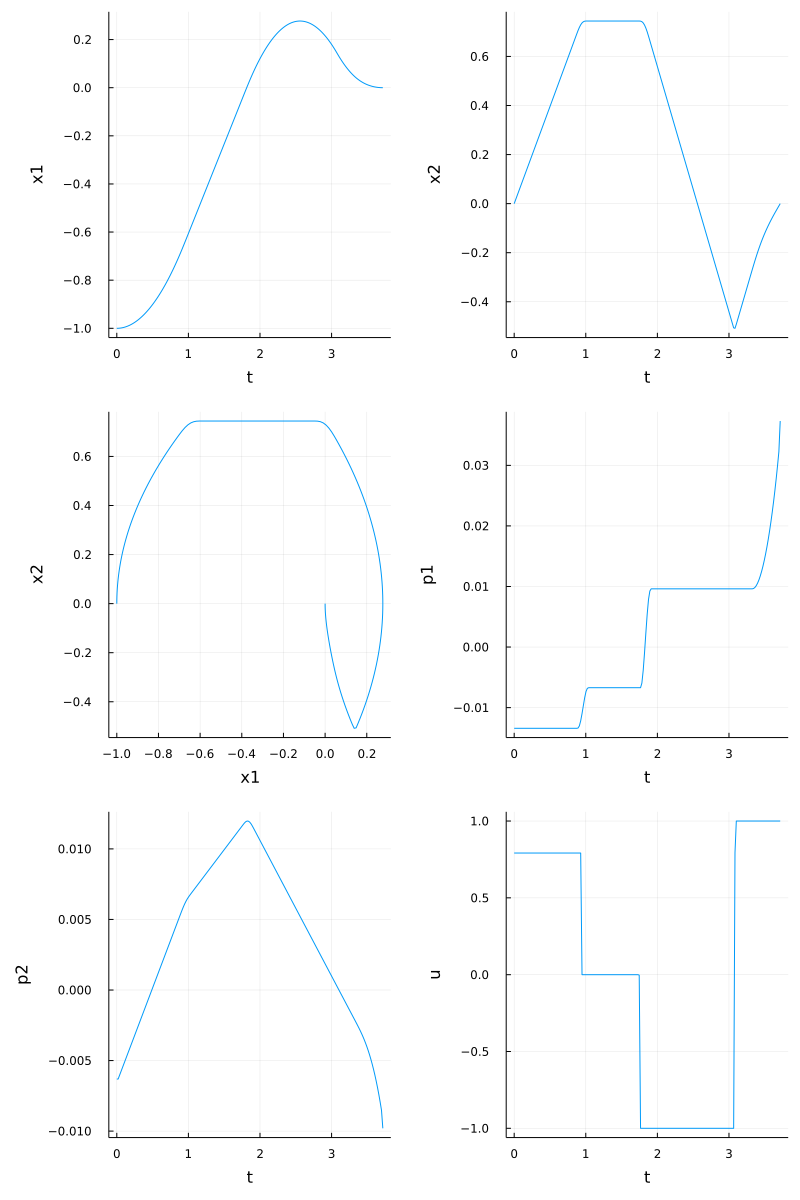

In [8]:
# Plots
t  = direct_sol.t
x1 = direct_sol.x1
x2 = direct_sol.x2
u  = [direct_sol.x3[1:switch_index]; direct_sol.u[switch_index+1:end]]
p1 = direct_sol.p1
p2 = direct_sol.p2

x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t, p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t, p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)

x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, p1_plot, p2_plot, u_plot, layout = (3,2), size=(800,1200), left_margin=10mm)

We can clearly identify four phases for this problem:

* Constant control phase;
* Zero control phase;
* Bang-bang control, with successively u = -1 then u = +1.

Each of these phases have their own properties and can be identified mathematically, provided a first study from the direct method results. Exploiting this knowledge, we can state the different phases from the indirect solving point of view, since we do not provide the complete dynamics of the system.


In particular, for our system, the Hamiltonian for a given phase is $H = H_0 + H_1\cdot u $; hence, the phases are identified this way:

* Constant control to zero control: when x1 > -0.65;
* Zero control to bang-bang (lower bound): x1's sign changes;
* Bang-bang (lower bound) to bang-bang (upper bound): pseudo-Hamiltonian's sign changes.

Moreover, we also use the results from direct method as initial guess for the indirect solving, exploiting the same properties that we identified for the indirect solving.

## Indirect solving

In [9]:
# Imports for indirect method
using NLsolve
include("flow.jl");

In [10]:
# Dynamics
function F0(x)
    return [ x[2], 0.0 ]
end

function F1(x)
    return [ 0., 1. ]
end

# Hamiltonians: permanent region
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

Hc(x, p, u) = H0(x, p) + u*H1(x,p) # pseudo-Hamiltonian

up(x, p) =  M
um(x, p) = -M

Hp(x, p) = Hc(x, p, up(x, p))
Hm(x, p) = Hc(x, p, um(x, p))

# Hamiltonian: no control region
Hc0(x, p) = H0(x, p)

# Hamiltonians: control loss region
Hnc(x, p, λ) = H0(x, p) + λ*H1(x,p) # pseudo-Hamiltonian
Hnc(X, P) = Hnc(X[1:2], P[1:2], X[3])

# Flows
fp  = Flow(Hp)
fm  = Flow(Hm)
fc0 = Flow(Hc0)
fnc = Flow(Hnc);

In [11]:
N       = length(t); # number of time steps
x       =  [ [ x1[i], x2[i] ] for i in 1:N ];
p       = -[ [ p1[i], p2[i] ] for i in 1:N ];
H1_span = H1.(x, p);

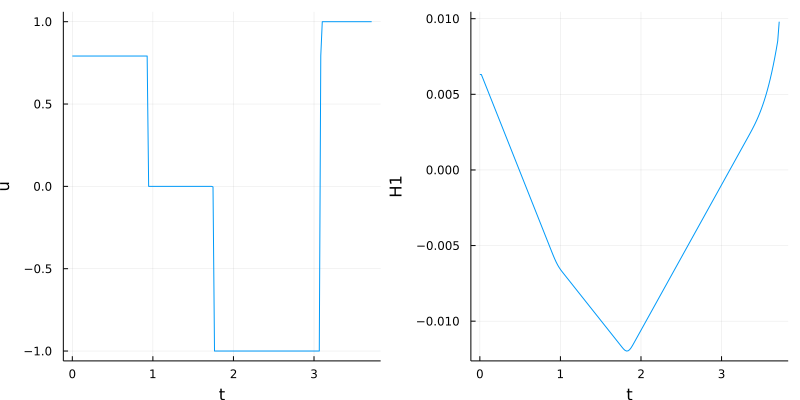

In [12]:
H1_plot = plot(t, H1_span, xlabel = "t", ylabel = "H1", legend = false)

display(plot(u_plot, H1_plot, layout = (1,2), size=(800,400)))

In [13]:
# Shooting function
# We know from direct method that the structure of the control is
# a constant region (λ) followed by bang-bang control (lower then upper bound)
function shootBλB0BmBp(p0, λ, t1, t2, t3, T, x0) # Bλ B0 B- B+ structure
    
    # Phase 1: constant control
    pλ0    = 0. # λ0 is free
    X1, P1 = fnc(t0, [x0; λ], [p0; pλ0], t1) # augmented flow
    
    # Phase 2: no control
    jump_magnitude_1 = P1[2]*(-λ)/X1[2]
    x2, p2 = fc0(t1, X1[1:2], [P1[1]-jump_magnitude_1, P1[2]], t2)
    #x2, p2 = fc0(t1, X1[1:2], [P1[1], P1[2]], t2)
    
    # Phase 3: bang-bang control, lower bound
    jump_magnitude_2 = p2[2]*(-M)/x2[2]
    x3, p3 = fm(t2, x2, [p2[1]-jump_magnitude_2, p2[2]], t3)
    
    # Phase 4: bang-bang control, upper bound
    xT, pT = fp(t3, x3, p3, T)
    
    s = zeros(eltype(p0), 7)
    
    s[1:2] = xT - [ x1f, x2f ] # target
    
    s[3] = X1[1] - no_control_bound # switching to u = 0 
    
    s[4] = H1(x3, p3)      # switching to u = +1
    s[5] = Hp(xT, pT) - 1. # free final time
    
    s[6] = x2[1] # crossing x1 = 0; u = -1
    s[7] = P1[3] # ∫ ∂H∂λ = 0 pris sur [t0, t1] 
        
    return s

end;

In [14]:
switch_index_1 = findall(x1[2:N] .> no_control_bound)[1];                                                   # switch for u =  0
switch_index_2 = switch_index_1 + findall(x1[switch_index_1+1:N].*x1[switch_index_1:N-1].<0)[1];            # switch for u = -1
switch_index_3 = switch_index_2 + findall(H1_span[switch_index_2+1:N].*H1_span[switch_index_2:N-1].<0.)[1]; # switch for u = +1

ts1 = t[switch_index_1];
ts2 = t[switch_index_2];
ts3 = t[switch_index_3];

println("First switch time: ",  ts1);
println("Second switch time: ", ts2);
println("Third switch time: ", ts3);

First switch time: 0.9289109142181479
Second switch time: 1.82066539186757
Third switch time: 3.102562453488614


In [15]:
# Solve
x0 = [-1.; 0.]

S(ξ) = shootBλB0BmBp(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7], x0)

p0 = [p1[1], p2[1]]
tf = direct_sol.t[end]
λs = direct_sol.x3[1]
# ξ contains shoot function parameters
ξ_guess = [p0..., λs, ts1, ts2, ts3, tf] # initial guess (from direct method)

println("Initial value of shooting:\n", S(ξ_guess), "\n\n")

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)
println("Final value of shooting:\n", S(indirect_sol.zero), "\n\n")

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    p0 = indirect_sol.zero[1:2]
    λ  = indirect_sol.zero[3]
    t1 = indirect_sol.zero[4]
    t2 = indirect_sol.zero[5]
    t3 = indirect_sol.zero[6]
    T  = indirect_sol.zero[7]
else
    error("Not converged")
end;

Initial value of shooting:
[-0.028780650249423726, 0.06655286031403253, -0.008453985681637022, -0.00036371023282586406, -1.0057241217301314, -0.0026856381903773052, 7.515869035458086e-5]


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.005724e+00              NaN
     1     9.853084e+00     4.578126e-16
     2     4.959772e+00     0.000000e+00
     3     8.294626e-01     2.220446e-16
     4     4.190181e-01     5.264489e-01
     5     1.793475e+00     6.206335e-17
     6     4.720322e-01     5.611772e-01
     7     3.493486e-01     2.257742e-01
     8     2.958390e-01     4.589893e-01
     9     2.841551e-01     4.749293e-01
    10     4.458390e-01     0.000000e+00
    11     2.392055e-01     6.818696e-01
    12     2.907312e-01     2.482534e-16
    13     1.406382e-01     6.969745e-01
    14     8.160577e-03     6.522708e-01
    15     9.046162e-05     1.030036e-02
    16     2.992035e-09     3.524767e-05
Results of Nonlinear Solver Algori

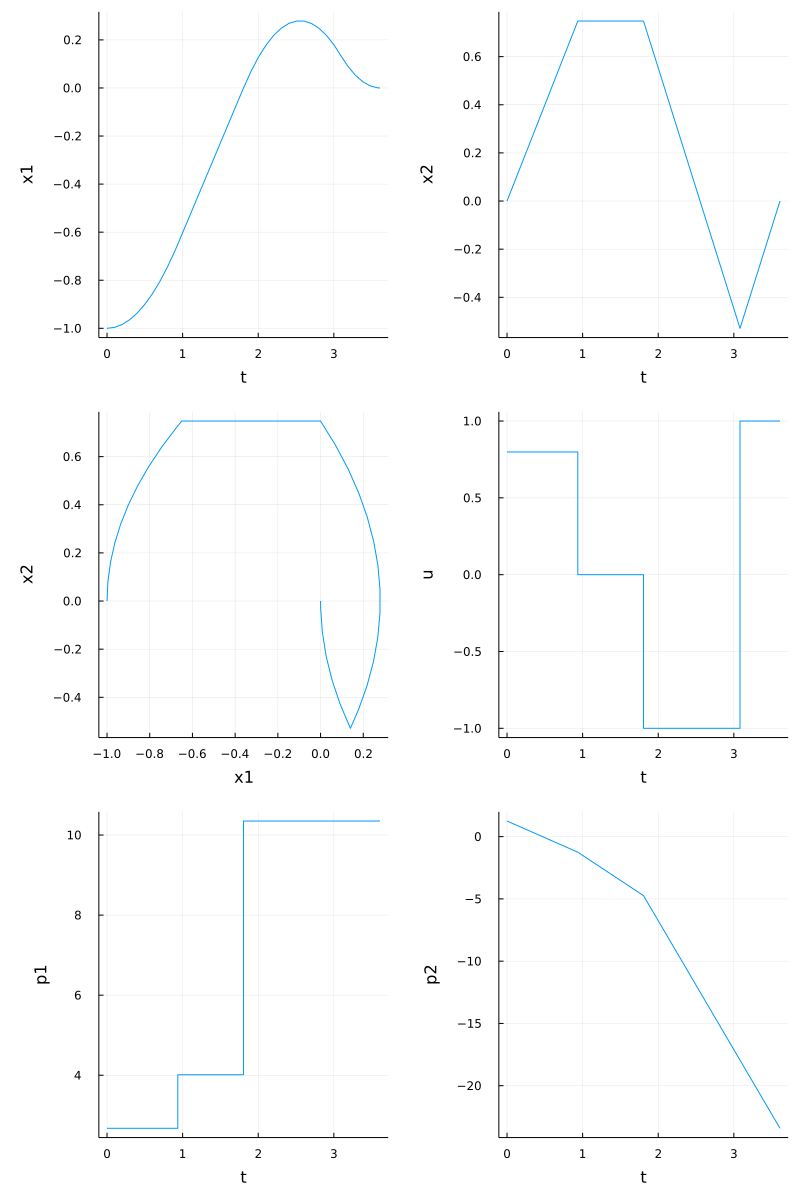

In [16]:
# plots

pλ0 = 0.
ode_sol = fnc((t0, t1), [x0; λ], [p0; pλ0], saveat=0.1)

tt1 = ode_sol.t
xx1 = [ ode_sol[1:2, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[4:5, j] for j in 1:size(tt1, 1) ]
uu1 = λ.*ones(length(tt1)) 

ν_1 = ode_sol[5, end]*(-λ)/ode_sol[2, end] # jump
ode_sol = fc0((t1, t2), xx1[end], pp1[end]+[ν_1, 0], saveat=0.1)

tt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[3:4, j] for j in 1:size(tt2, 1) ]
uu2 = zeros(size(tt2, 1))

ν_2 = ode_sol[4, end]*(-M)/ode_sol[2, end] # jump
ode_sol = fm((t2, t3), xx2[end], pp2[end]+[ν_2, 0], saveat=0.1)

tt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(tt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(tt3, 1) ]
uu3 = um.(xx3, pp3)

ode_sol = fp((t3, T), xx3[end], pp3[end], saveat=0.1)

tt4 = ode_sol.t
xx4 = [ ode_sol[1:2, j] for j in 1:size(tt4, 1) ]
pp4 = [ ode_sol[3:4, j] for j in 1:size(tt4, 1) ]
uu4 = up.(xx4, pp4)

t = [ tt1 ; tt2 ; tt3 ; tt4 ]
x = [ xx1 ; xx2 ; xx3 ; xx4 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ]

m = length(t)
x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot, p2_plot, layout = (3,2), size=(800,1200), left_margin=10mm)